### question 3

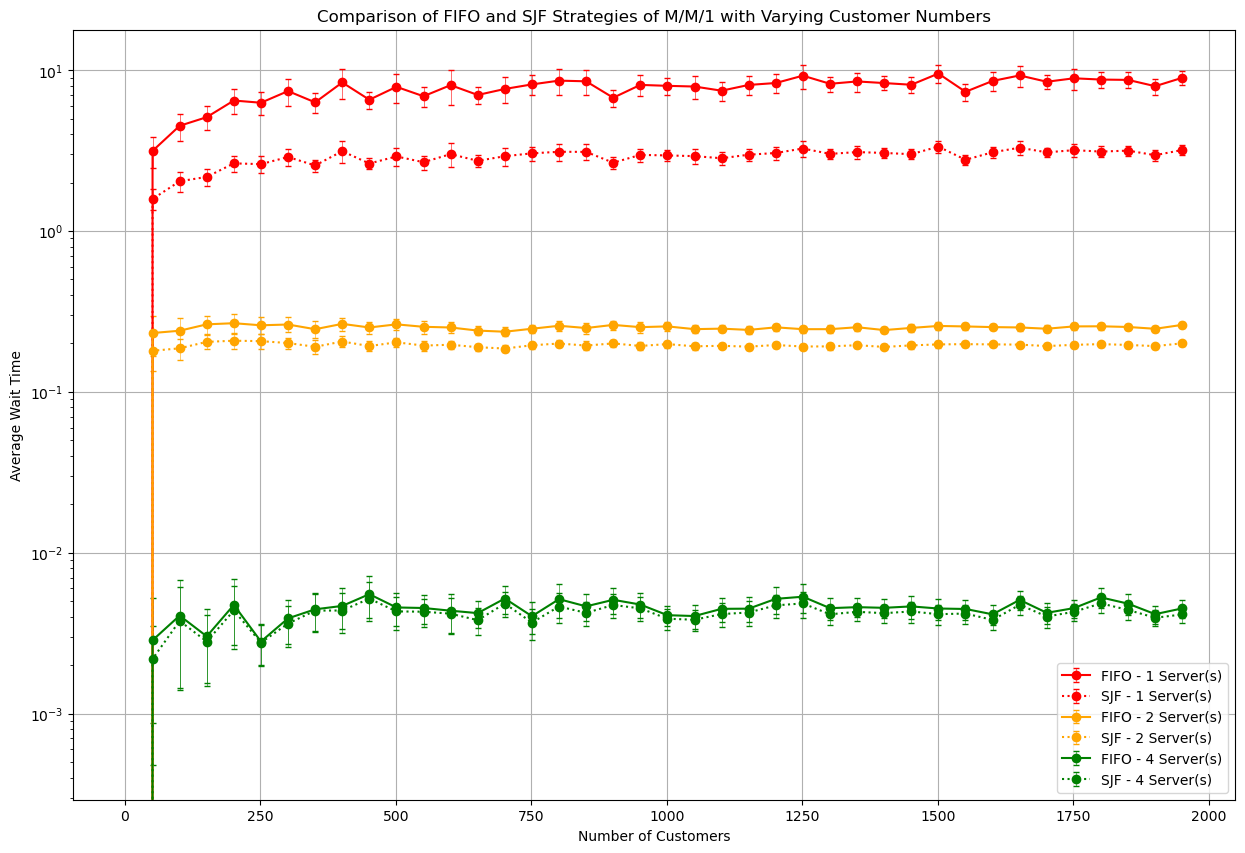

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import statistics

# Assuming λ (arrival rate) and μ (service rate) are defined
λ = 0.9  # Example value
μ = 1.0  # Example value
servers = [1, 2, 4]  # Example server configurations

def generate_customers(num_customers):
    """Generate customers with random arrival and service times."""
    interarrival_times = np.random.exponential(1/λ, num_customers)
    service_times = np.random.exponential(1/μ, num_customers)
    arrival_times = np.cumsum(interarrival_times)
    return arrival_times, service_times

def process_customers_fifo(arrival_times, service_times, num_servers):
    """Process customers in FIFO order."""
    num_customers = len(arrival_times)
    wait_times = np.zeros(num_customers)
    service_ends = np.zeros(num_servers)

    for i in range(num_customers):
        next_server = np.argmin(service_ends)
        service_start = max(service_ends[next_server], arrival_times[i])
        service_ends[next_server] = service_start + service_times[i]
        wait_times[i] = service_start - arrival_times[i]

    return wait_times

def process_customers_sjf(arrival_times, service_times, num_servers):
    """Process customers in SJF order."""
    num_customers = len(arrival_times)
    wait_times = np.zeros(num_customers)
    service_ends = np.zeros(num_servers)
    processed = np.zeros(num_customers, dtype=bool)

    for _ in range(num_customers):
        # Select the next customer: shortest job among those who have arrived
        available = (arrival_times <= np.min(service_ends)) & (~processed)
        if not available.any():
            # If no one has arrived yet, pick the first unprocessed customer
            next_customer = np.where(~processed)[0][0]
        else:
            next_customer = np.where(available)[0][np.argmin(service_times[available])]

        next_server = np.argmin(service_ends)
        service_start = max(service_ends[next_server], arrival_times[next_customer])
        service_ends[next_server] = service_start + service_times[next_customer]
        wait_times[next_customer] = service_start - arrival_times[next_customer]
        processed[next_customer] = True

    return wait_times

# Simulation parameters
customer_numbers = range(1, 2001, 50)  # Range of customer numbers to simulate
num_runs = 50  # Number of simulation runs

average_wait_times_fifo = {n: {'averages': [], 'std_devs': [], 'conf_diams': []} for n in servers}
average_wait_times_sjf = {n: {'averages': [], 'std_devs': [], 'conf_diams': []} for n in servers}

# Simulation
for n in servers:
    for num_customers in customer_numbers:
        fifo_waits_all_runs = []
        sjf_waits_all_runs = []

        for run in range(num_runs):
            random.seed(42 + run)
            arrival_times, service_times = generate_customers(num_customers)

            # FIFO simulation
            fifo_waits = process_customers_fifo(arrival_times, service_times, n)
            fifo_waits_all_runs.append(np.mean(fifo_waits))

            # SJF simulation
            sjf_waits = process_customers_sjf(arrival_times, service_times, n)
            sjf_waits_all_runs.append(np.mean(sjf_waits))

        # Data aggregation
        fifo_avg = statistics.mean(fifo_waits_all_runs)
        fifo_std_dev = statistics.stdev(fifo_waits_all_runs)
        sjf_avg = statistics.mean(sjf_waits_all_runs)
        sjf_std_dev = statistics.stdev(sjf_waits_all_runs)
        fifo_conf_diam = 1.96 * fifo_std_dev / np.sqrt(num_runs)
        sjf_conf_diam = 1.96 * sjf_std_dev / np.sqrt(num_runs)

        average_wait_times_fifo[n]['averages'].append(fifo_avg)
        average_wait_times_fifo[n]['std_devs'].append(fifo_std_dev)
        average_wait_times_fifo[n]['conf_diams'].append(fifo_conf_diam)
        average_wait_times_sjf[n]['averages'].append(sjf_avg)
        average_wait_times_sjf[n]['std_devs'].append(sjf_std_dev)
        average_wait_times_sjf[n]['conf_diams'].append(sjf_conf_diam)

# Plotting
plt.figure(figsize=(15, 10))
color_map = {1: 'red', 2: 'orange', 4: 'green'}

for n in servers:
    plt.errorbar(customer_numbers, average_wait_times_fifo[n]['averages'], 
                 yerr=average_wait_times_fifo[n]['conf_diams'], 
                 label=f'FIFO - {n} Server(s)', 
                 fmt='o-', color=color_map[n], ecolor=color_map[n], elinewidth=0.4, capsize=2)
    plt.errorbar(customer_numbers, average_wait_times_sjf[n]['averages'], 
                 yerr=average_wait_times_sjf[n]['conf_diams'], 
                 label=f'SJF - {n} Server(s)', 
                 fmt='o:', color=color_map[n], ecolor=color_map[n], elinewidth=0.4, capsize=2)

plt.xlabel('Number of Customers')
plt.ylabel('Average Wait Time')
plt.yscale('log')
plt.title('Comparison of FIFO and SJF Strategies of M/M/1 with Varying Customer Numbers')
plt.legend()
plt.grid(True)
plt.show()


### question 4 - M/D/n & Long-tail distribution

In [ ]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

### M/D/n, n = [1, 2, 4]

- We set service time equal to 2, which is the same as the expectation of hyperexponential distribution we will use later.
- We set $\rho = 0.9$ to observe potential unstable situation.

In [ ]:
# the behavior of a customer in the queue
def customer(env, name, service_time, resource, wait_times):
    arrival_time = env.now
    with resource.request() as req:
        # wait for the service station available
        yield req
        wait_time = env.now - arrival_time
        wait_times.append(wait_time)
        
        # simulate the service process
        yield env.timeout(service_time)

        
# generate customers over time
def generate_customers(env, arrival_interval, service_time, resource, num_customers, wait_times):
    for i in range(num_customers):
        # wait for the next arrival
        yield env.timeout(np.random.exponential(arrival_interval))

        env.process(customer(env, f"Customer {i}", service_time, resource, wait_times))

        
# simulate the entire queue
def simulate_queue(num_customers, arrival_interval, service_time, num_servers):
    env = simpy.Environment()
    resource = simpy.Resource(env, capacity=num_servers)
    wait_times = []
    
    env.process(generate_customers(env, arrival_interval, service_time, resource, num_customers, wait_times))
    env.run()
    
    average_wait = np.mean(wait_times) if wait_times else 0
    return average_wait

In [ ]:
service_time = 2.0
rho = 0.9

# set number of servers equal to 1 to get proportional arrival interval
arrival_interval = service_time / (rho * 1)

customer_counts = np.logspace(1, 6, 200, base=10).astype(int)
num_servers = [1, 2, 4]
color_list = ['#3498db', '#e74c3c', '#2ecc71']

plt.figure(figsize=(9, 5))

for i, servers in enumerate(num_servers):
    average_waits = []
    for count in customer_counts:
        avg_wait = simulate_queue(count, arrival_interval, service_time, num_servers[i])
        average_waits.append(avg_wait)
        
    mean_avg_waits = np.mean(average_waits)

    plt.plot(customer_counts, average_waits, color=color_list[i], label=f'n={num_servers[i]}')
    plt.axhline(mean_avg_waits, color=color_list[i], linestyle='--', label=f'n={num_servers[i]}, mean')
    
plt.xlabel('Number of Customers')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time vs Number of Customers')
plt.legend()
plt.savefig("MDn", dpi=300)

### Long-tail Distribution

In [ ]:
# slightly different from M/D/n func: built-in service time and remove the input parameter

def customer_longtail(env, name, resource, wait_times):
    arrival_time = env.now
    
    # built-in service time
    if np.random.rand() < 0.75:
        service_time = np.random.exponential(1.0)
    else:
        service_time = np.random.exponential(5.0)

    with resource.request() as req:
        yield req
        wait_time = env.now - arrival_time
        wait_times.append(wait_time)

        yield env.timeout(service_time)


def generate_customers_longtail(env, arrival_interval, resource, num_customers, wait_times):
    for i in range(num_customers):
        yield env.timeout(np.random.exponential(arrival_interval))
        
        env.process(customer_longtail(env, f"Customer {i}", resource, wait_times))


def simulate_queue_longtail(num_customers, arrival_interval, num_servers):
    env = simpy.Environment()
    resource = simpy.Resource(env, capacity=num_servers)
    wait_times = []
    
    env.process(generate_customers_longtail(env, arrival_interval, resource, num_customers, wait_times))
    env.run()
    
    average_wait = np.mean(wait_times) if wait_times else 0
    return average_wait

In [ ]:
# the expected service time of hyperexponential distribution is 2.0
expected_service_time = 2.0
rho = 0.9
arrival_interval = expected_service_time / (rho * 1)

customer_counts = np.logspace(1, 6, 200, base=10).astype(int)
num_servers = [1, 2, 4]
color_list = ['#3498db', '#e74c3c', '#2ecc71']

plt.figure(figsize=(9, 5))

for i, servers in enumerate(num_servers):
    average_waits = []
    for count in customer_counts:
        avg_wait = simulate_queue_longtail(count, arrival_interval, num_servers[i])
        average_waits.append(avg_wait)

    plt.plot(customer_counts, average_waits, color=color_list[i], label=f'n={num_servers[i]}')

plt.xscale('log')
plt.xlabel('Number of Customers')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time (Long tail) vs Number of Customers')
plt.legend()
plt.savefig("long_tail", dpi=300)

### Comparison between M/D/1 and Long tail distribution

- Exploration of queueing explosion
- Change $\rho$ from 0.9 to 0.999, compare M/D/1 and Long tail distribution

In [ ]:
service_time = 2.0
rhos = [0.9, 0.99, 0.999]
num_servers = 1

customer_counts = np.logspace(1, 6, 200, base=10).astype(int)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, rho in enumerate(rhos):
    arrival_interval = service_time / (rho * num_servers)
    average_waits = []
    average_waits_longtail = []
    for count in customer_counts:
        avg_wait = simulate_queue(count, arrival_interval, service_time, num_servers)
        average_waits.append(avg_wait)
        avg_wait_longtail = simulate_queue_longtail(count, arrival_interval, num_servers)
        average_waits_longtail.append(avg_wait_longtail)
        
        
    ax = axes[i]
    ax.plot(customer_counts, average_waits, label='M/D/1')
    ax.plot(customer_counts, average_waits_longtail, label='Long tail')
    ax.set_xscale('log')
    ax.set_xlabel('Number of Customers')
    ax.set_ylabel('Average Waiting Time')
    ax.set_title(f'$rho = {rho}$')
    ax.legend()
    
fig.suptitle('Comparison between M/D/1 and Long tail distribution')
#plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('comparison', dpi=300)